In [ ]:
import geohash
import pandas as pd
import numpy as np
import sklearn.model_selection as ms
import matplotlib.pyplot as plt
from sklearn.cluster import OPTICS



In [ ]:
data_set = pd.read_csv('data_set.csv', header=None)

# 时间的格式为: 2017-05-15 17:37:54
# 将数据按照time进行分类
data_set = np.array(data_set)
data_in_hour = {}
for el in data_set[1:]:
    el_time = el[4].split('-')
    day = int(el_time[2].split(' ')[0])
    hour = int(el_time[2].split(' ')[1].split(':')[0])
    hours = day * 24 + hour
    if hours not in data_in_hour:
        data_in_hour[hours] = []
    else:
        data_in_hour[hours].append(el)

# save the data in each hour to csv file
for key in data_in_hour:
    data_in_hour[key] = pd.DataFrame(data_in_hour[key])
    data_in_hour[key].to_csv('data\data_in_hour'+str(key)+'.csv')
        
print(data_in_hour.keys())
    

In [ ]:
import geohash
for i in range(240, 596):
    try:
        data_at_time = pd.read_csv('data\data_in_hour'+str(i)+'.csv', header=None)
    except:
        continue
    data_at_time = np.array(data_at_time)
    data_at_time = data_at_time[1:, 6:8]
    
    start_pos = []
    end_pos = []
    
    for each_data in data_at_time:
        start_pos.append(geohash.decode(each_data[0]))
        end_pos.append(geohash.decode(each_data[1]))
    
    # save position to csv file
    pd.DataFrame(start_pos).to_csv('start_pos\\startpos'+str(i)+'.csv')
    pd.DataFrame(end_pos).to_csv('end_pos\\endpos'+str(i)+'.csv')
    

In [ ]:
from sklearn.cluster import OPTICS
optics = OPTICS(min_samples=300, xi=0.01, min_cluster_size=None)

for i in range(240, 596):
    try:
        data_at_time = pd.read_csv('start_pos\\startpos'+str(i)+'.csv', header=None)
    except:
        continue
    data_at_time = np.array(data_at_time[1:])
    data_at_time = data_at_time[:, 1:]
        
    try:
        cluster_labels = optics.fit_predict(data_at_time)
    except:
        continue
    # remove the -1 label and the corresponding data
    data_at_time = data_at_time[cluster_labels != -1]
    cluster_labels = cluster_labels[cluster_labels != -1]
    
    plt.scatter(data_at_time[:,0], data_at_time[:,1], c=cluster_labels)
    plt.savefig('after_cluster\position_area'+str(i)+'.png')
    

由上聚类可估计城区范围(39.5, 116.0)~(40.2,116.8)

In [ ]:
# 按照城区范围将城区分为50*50的网格
# 城区范围(39.5, 116.0)~(40.2,116.8)
time_heatmap = []
for i in range(240, 596):
    try:
        data_at_time = pd.read_csv('start_pos\\startpos'+str(i)+'.csv', header=None)
    except:
        continue
    # 将范围外的点去除
    data_at_time = np.array(data_at_time[1:])
    data_at_time = data_at_time[:, 1:]
    data_at_time = data_at_time[data_at_time[:,0] <= 40.2]
    data_at_time = data_at_time[data_at_time[:,0] >= 39.5]
    data_at_time = data_at_time[data_at_time[:,1] <= 116.8]
    data_at_time = data_at_time[data_at_time[:,1] >= 116.0]
    # 将经纬度转换为网格坐标
    data_at_time[:,0] = (data_at_time[:,0] - 39.5) / 0.7 * 50
    data_at_time[:,1] = (data_at_time[:,1] - 116.0) / 0.8 * 50
    # 计算heatmap
    heatmap = np.zeros((50, 50))
    for each_data in data_at_time:
        heatmap[int(each_data[0]), int(each_data[1])] += 1
    # 保存heatmap为png
    plt.imshow(heatmap)
    plt.savefig('heatmap_start\heatmap_start'+str(i)+'.png')
    
    time_heatmap.append(heatmap)

time_heatmap = np.array(time_heatmap)
np.savetxt('time_heatmap_start.csv', time_heatmap.reshape(-1), delimiter=',')

time_heatmap = []
# 计算结束位置
for i in range(240, 596):
    try:
        data_at_time = pd.read_csv('end_pos\\endpos'+str(i)+'.csv', header=None)
    except:
        continue
    data_at_time = np.array(data_at_time[1:])
    data_at_time = data_at_time[:, 1:]
    data_at_time = data_at_time[data_at_time[:,0] <= 40.2]
    data_at_time = data_at_time[data_at_time[:,0] >= 39.5]
    data_at_time = data_at_time[data_at_time[:,1] <= 116.8]
    data_at_time = data_at_time[data_at_time[:,1] >= 116.0]
    
    data_at_time[:,0] = (data_at_time[:,0] - 39.5) / 0.7 * 50
    data_at_time[:,1] = (data_at_time[:,1] - 116.0) / 0.8 * 50
    
    heatmap = np.zeros((50, 50))
    for each_data in data_at_time:
        heatmap[int(each_data[0]), int(each_data[1])] += 1
    
    plt.imshow(heatmap)
    plt.savefig('heatmap_end\heatmap_end'+str(i)+'.png')
    
    time_heatmap.append(heatmap)

time_heatmap = np.array(time_heatmap)
np.savetxt('time_heatmap_end.csv', time_heatmap.reshape(-1), delimiter=',')
    

In [ ]:
# load heatmap from csv
time_heatmap = np.loadtxt('time_heatmap.csv', delimiter=',').reshape(-1, 50, 50)

plt.imshow(time_heatmap[1])

In [ ]:
time_heatmap_start = np.loadtxt('time_heatmap_start.csv', delimiter=',').reshape(-1, 50, 50)
time_heatmap_end = np.loadtxt('time_heatmap_end.csv', delimiter=',').reshape(-1, 50, 50)

# 初始状态每个地区的储量为10
store_amount = np.ones((50, 50)) * 10

import seaborn as sns
# 模拟自行车的迁移过程, 绘制高度图
for i, (start, end) in enumerate(zip(time_heatmap_start, time_heatmap_end)):
    store_amount = store_amount - start + end
    sns.heatmap(store_amount, vmin=-1000, vmax=1000, cmap='RdBu_r')
    plt.savefig('store_amount\store_amount'+str(i)+'.png')
    plt.clf()
    

In [ ]:
from matplotlib import animation

# plot gif
fig = plt.figure()
ims = []
for i in range(356):
    try:
        # read from file
        im = plt.imread('store_amount\store_amount'+str(i)+'.png')
    except:
        continue
    ims.append([plt.imshow(im)])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
#AttributeError: 'numpy.ndarray' object has no attribute 'set_visible'
ani.save('store_amount.gif', writer='imagemagick', fps=10)

先以自行车的利用率为指标进行计算
$$利用率 = \frac{利用的自行车数}{总的自行车数}$$


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

time_heatmap_start = np.loadtxt('time_heatmap_start.csv', delimiter=',').reshape(-1, 50, 50)
time_heatmap_end = np.loadtxt('time_heatmap_end.csv', delimiter=',').reshape(-1, 50, 50)

# 初始状态每个地区的储量
store_amount = []
store_amount.append(np.ones((50, 50)) * 0)

import seaborn as sns
# 模拟自行车的迁移过程
for i, (start, end) in enumerate(zip(time_heatmap_start, time_heatmap_end)):
    store_amount.append(store_amount[i] - start + end)
    
# 计算不同时间的自行车利用率
sum_num = 0
bike_num = []
used_rate = []
for i, (need, stored) in enumerate(zip(time_heatmap_start, store_amount)):
    # 去store_amount除负值
    bike_num.append(np.sum(stored[stored < 0]) * -1)
    sum_num += np.sum(stored[stored < 0]) * -1
    stored[stored < 0] = 0
    
    # 取need和stored中的较小值
    used = np.minimum(need, stored)
    used_rate.append(np.sum(used) / sum_num)

plt.subplot(211)
plt.plot(used_rate)
plt.xlabel('time')
plt.ylabel('used rate')
plt.subplot(212)
plt.plot(bike_num)
plt.xlabel('time')
plt.ylabel('bike num')
plt.show()    
    

由上图可知, 如果不对已有的单车进行调度, 则需要不断引入新的单车来满足需求, 且对现有单车的利用率会一直很低, 所以我们需要考虑一种调度策略来提高利用率, 减少单车引入量

为了对调度算法有一个合理的估计, 我们先求出理论最优的调度方案, 即已经存在的单车可以全部得到利用的情况下的单车引入量

In [ ]:
exist_bike = [0]
for i, stored in enumerate(time_heatmap_start):
    exist_bike.append(max(exist_bike[i], np.sum(stored)))
    
print(exist_bike[-1])

plt.plot(exist_bike)
plt.xlabel('time')
plt.ylabel('exist bike')
plt.show()

In [ ]:
# 指数加权平均
def ewma(x, alpha):
    y = [x[0]]
    for i in range(1, len(x)):
        y.append(alpha *  y[i-1] + (1 - alpha) * x[i])
    return y

理论最优只需要33577辆车就可以满足需求

## 方案一: 范围搜索调度(红包车调度)
如果一个点缺少自行车, 先按照广度优先搜索, 搜索一定范围内的自行车储存, 如果储存量够, 则优先从此调度自行车, 否则从外界引入新的自行车
这个调度过程可以分配给用户完成, 一个缺少自行车的区域向周围多出来的自行车区域寻求调度, 等同于准备将自行车停入周围区域的用户将自行车改变目的地到缺少自行车的区域, 从而实现自行车的调度

所以这个向周围区域寻求调度的过程, 可以转化为向周围骑行用户发放红包, 使其骑行到缺失点的一个方案

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

time_heatmap_start = np.loadtxt(
    'time_heatmap_start.csv', delimiter=',').reshape(-1, 50, 50)
time_heatmap_end = np.loadtxt(
    'time_heatmap_end.csv', delimiter=',').reshape(-1, 50, 50)


def get_bike_from_ranged_store(stored, x, y):
    visited = np.zeros((50, 50))
    search_queue = [(x, y, 0)]
    schedual_cost = 0

    while search_queue and stored[x, y] < 0:
        x_s, y_s, searching_deep = search_queue.pop(0)
        for x_n, y_n in [(x_s-1, y_s), (x_s+1, y_s), (x_s, y_s-1), (x_s, y_s+1)]:
            if x_n < 0 or x_n >= 50 or y_n < 0 or y_n >= 50:
                continue
            if visited[x_n, y_n] == 0:
                search_queue.append((x_n, y_n, searching_deep+1))
                visited[x_n, y_n] = 1
        if searching_deep > 5:
            break
        if stored[x_s, y_s] <= 0:
            continue
        move_num = min(stored[x_s, y_s], -stored[x, y])
        stored[x_s, y_s] -= move_num
        stored[x, y] += move_num
        schedual_cost += move_num * searching_deep

    return stored, schedual_cost


store_amount_case_1 = []
store_amount_case_1.append(np.ones((50, 50)) * 0)

bike_num = [0]
schedual_cost_list = [0]
used_rate = []

for i, (need, moved) in enumerate(zip(time_heatmap_start, time_heatmap_end)):
    stored = store_amount_case_1[i].copy() - need

    cost_all = 0

    for x, y in np.argwhere(stored < 0):
        stored, schedual_cost = get_bike_from_ranged_store(stored, x, y)
        cost_all += schedual_cost

    bike_num.append(bike_num[i] + np.sum(stored[stored < 0]) * -1)
    stored[stored < 0] = 0

    stored += moved
    schedual_cost_list.append(schedual_cost_list[i] + cost_all)

    used_rate.append((np.sum(need) - (bike_num[i+1] - bike_num[i])) / (bike_num[i] + 0.00001))

    store_amount_case_1.append(stored)

used_rate_ewma = ewma(used_rate, 0.9)
print(used_rate_ewma)

plt.subplot(211)
plt.plot(schedual_cost_list)
plt.xlabel('time')
plt.ylabel('schedual cost')
plt.subplot(212)
plt.plot(bike_num)
plt.xlabel('time')
plt.ylabel('bike num')

plt.show()
plt.plot(used_rate, 'b')
plt.xlabel('time')
plt.ylabel('used rate')
plt.plot(used_rate_ewma, 'r')
plt.show()

## 方案2: 车辆集中调度
通过将50*50的栅格建立成一个图, 我们的问题可以抽象为图上问题, 有一个图, 每个节点上有一个整数(可负), 我们可以将一个节点上的值减去x并加到相邻的某个节点上, 并且产生x的成本, 现在需要所有节点都为非负, 操作使得成本最小

这问题可以当作一个最小费用最大流问题

In [ ]:

import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import maximum_flow, csgraph_from_dense, floyd_warshall




接下来我们尽量在该成本下寻求可行调度方案

In [ ]:
time_heatmap_start = np.loadtxt(
    'time_heatmap_start.csv', delimiter=',').reshape(-1, 50, 50)
time_heatmap_end = np.loadtxt(
    'time_heatmap_end.csv', delimiter=',').reshape(-1, 50, 50)

for i, (start, end) in enumerate(zip(time_heatmap_start, time_heatmap_end)):
    store_amount.append(store_amount[i] - start + end)
    

In [ ]:
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt

num_points = 50

points_coordinate = np.random.rand(num_points, 2)  # generate coordinate of points
print(points_coordinate)
distance_matrix = spatial.distance.cdist(points_coordinate, points_coordinate, metric='euclidean')


def cal_total_distance(routine):
    '''The objective function. input routine, return total distance.
    cal_total_distance(np.arange(num_points))
    '''
    num_points, = routine.shape
    return sum([distance_matrix[routine[i % num_points], routine[(i + 1) % num_points]] for i in range(num_points)])


# %% do GA
# 试试遗传算法库
from sko.GA import GA_TSP

ga_tsp = GA_TSP(func=cal_total_distance, n_dim=num_points, size_pop=50, max_iter=500, prob_mut=1)
best_points, best_distance = ga_tsp.run()
print(best_points)

# %% plot
fig, ax = plt.subplots(1, 2)
best_points_ = np.concatenate([best_points, [best_points[0]]])
best_points_coordinate = points_coordinate[best_points_, :]
print(best_points_coordinate.shape)
ax[0].plot(best_points_coordinate[:, 0], best_points_coordinate[:, 1], 'o-r')
ax[1].plot(ga_tsp.generation_best_Y)
plt.show()

在进行遗传算法估计路线前, 一个小时的时间粒度过小, 不便于安排运输车辆的路线, 所以我们将按照工作时间进行分割, 将一天分为两个时间段来进行路线安排
第一个时间段是凌晨12点到中午12点, 第二个时间段是中午12点到凌晨12点, 相当于把夜间少量的自行车需求在在白天完成调度

接下来先处理数据:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

time_heatmap_start = np.loadtxt(
    'time_heatmap_start.csv', delimiter=',').reshape(-1, 50, 50)
time_heatmap_end = np.loadtxt(
    'time_heatmap_end.csv', delimiter=',').reshape(-1, 50, 50)

# 按照12个小时进行划分
time_heatmap_12 = []
times = 0
temp_heatmap = np.zeros((50, 50))
for heatmap in time_heatmap_start:
    temp_heatmap += heatmap
    times += 1
    if times == 12:
        time_heatmap_12.append(temp_heatmap)
        times = 0
        temp_heatmap = np.zeros((50, 50))
time_heatmap_12.append(temp_heatmap)
np.savetxt('time_heatmap_12.csv', np.array(time_heatmap_12).reshape(-1, 50*50), delimiter=',')

time_heatmap_12 = []
times = 0
temp_heatmap = np.zeros((50, 50))
for heatmap in time_heatmap_end:
    temp_heatmap += heatmap
    times += 1
    if times == 12:
        time_heatmap_12.append(temp_heatmap)
        times = 0
        temp_heatmap = np.zeros((50, 50))
time_heatmap_12.append(temp_heatmap)
np.savetxt('time_heatmap_12_end.csv', np.array(time_heatmap_12).reshape(-1, 50*50), delimiter=',')

plt.imshow(time_heatmap_12[5])
plt.show()

In [ ]:
# 对库中的函数做一些调整, 以便于使用
from sko.GA import *
import random
class PathTSP(GeneticAlgorithmBase):
    def __init__(self, func, n_dim, size_pop=50, max_iter=200, prob_mut=0.001, rand_range = 2500):
        super().__init__(func, n_dim, size_pop=size_pop, max_iter=max_iter, prob_mut=prob_mut)
        self.has_constraint = False
        self.len_chrom = self.n_dim
        self.rand_range = rand_range
        self.crtbp()

    def crtbp(self):
        # create the population
        # 生成不重复的随机数
        tmp = np.random.randint(0, self.rand_range, size=(self.size_pop, self.len_chrom))
        self.Chrom = tmp
        return self.Chrom

    def chrom2x(self, Chrom):
        return Chrom

    ranking = ranking.ranking
    selection = selection.selection_tournament_faster
    mutation = mutation.mutation_reverse
    
    def crossover(self):
        # crossover
        Chrom = self.Chrom
        size_pop, len_chrom = Chrom.shape
        for i in range(0, size_pop, 2):
            cross_points = np.random.randint(0, 2, size=len_chrom).astype(np.bool)
            cross_points[0] = True
            cross_points[-1] = True
            Chrom[i, cross_points] = Chrom[i + 1, cross_points]
            Chrom[i + 1, cross_points] = Chrom[i, cross_points]
        self.Chrom = Chrom

    def run(self, max_iter=None):
        self.max_iter = max_iter or self.max_iter
        for i in range(self.max_iter):
            
            Chrom_old = self.Chrom.copy()
            self.X = self.chrom2x(self.Chrom)
            self.Y = self.x2y()
            self.ranking()
            self.selection()
            self.crossover()
            self.mutation()

            # put parent and offspring together and select the best size_pop number of population
            self.Chrom = np.concatenate([Chrom_old, self.Chrom], axis=0)
            self.X = self.chrom2x(self.Chrom)
            self.Y = self.x2y()
            self.ranking()
            selected_idx = np.argsort(self.Y)[:self.size_pop]
            self.Chrom = self.Chrom[selected_idx, :]

            # record the best ones
            generation_best_index = self.FitV.argmax()
            self.generation_best_X.append(self.X[generation_best_index, :].copy())
            self.generation_best_Y.append(self.Y[generation_best_index])
            self.all_history_Y.append(self.Y.copy())
            self.all_history_FitV.append(self.FitV.copy())

        global_best_index = np.array(self.generation_best_Y).argmin()
        self.best_x = self.generation_best_X[global_best_index]
        self.best_y = self.func(np.array([self.best_x]))
        return self.best_x, self.best_y


C:\Users\12721\AppData\Local\Temp\ipykernel_12828\3121814078.py:31: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cross_points = np.random.randint(0, 2, size=len_chrom).astype(np.bool)


nan
第1个时刻, 有0辆车


C:\Users\12721\AppData\Local\Temp\ipykernel_12828\1966938152.py:86: RuntimeWarning: invalid value encountered in double_scalars
  used_rate_list.append(used_bike_on_graph/(sum_bike_on_graph))
C:\Users\12721\AppData\Local\Temp\ipykernel_12828\1966938152.py:87: RuntimeWarning: invalid value encountered in double_scalars
  print(used_bike_on_graph/sum_bike_on_graph)


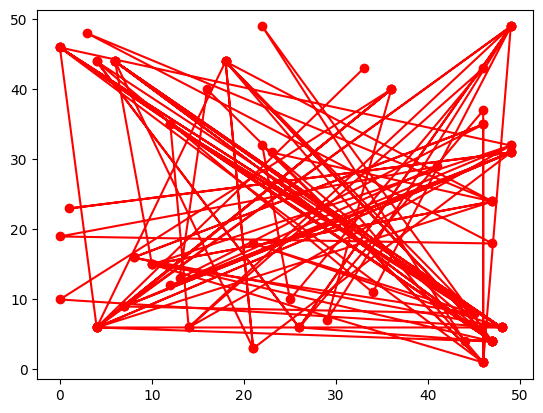

243.0
第2个时刻, 有-3辆车


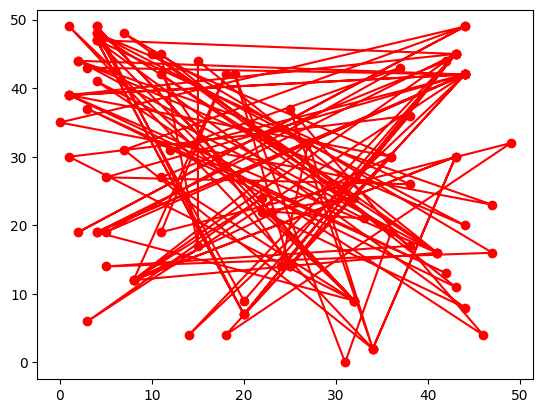

0.938808634961857
第3个时刻, 有12322辆车


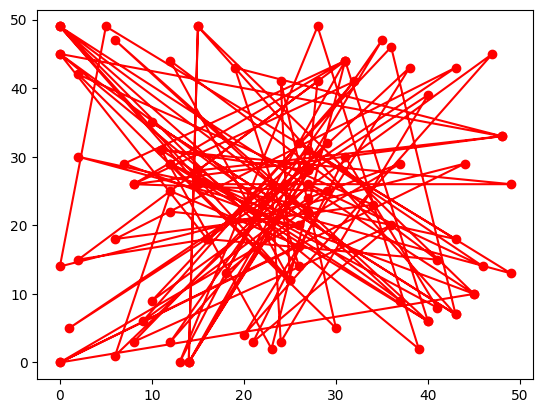

0.7571314798725746
第4个时刻, 有20718辆车


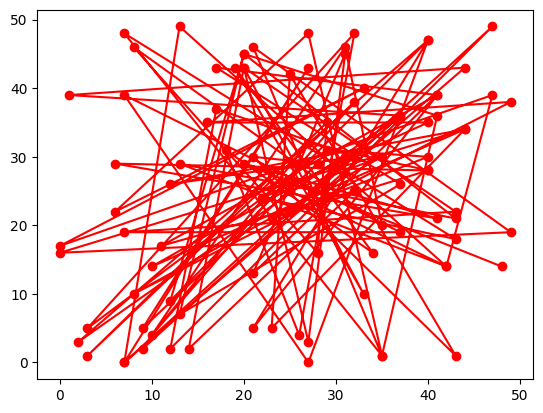

0.8207658002038736
第5个时刻, 有27468辆车


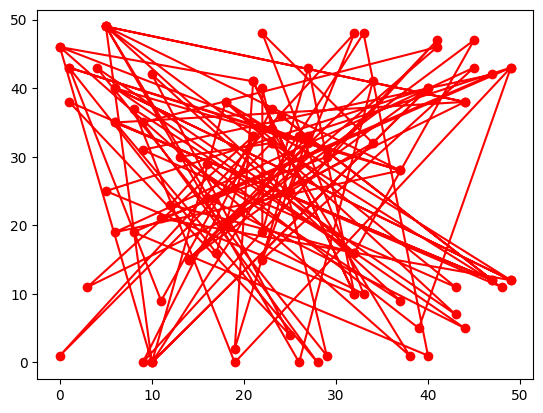

0.5123337740811829
第6个时刻, 有35167辆车


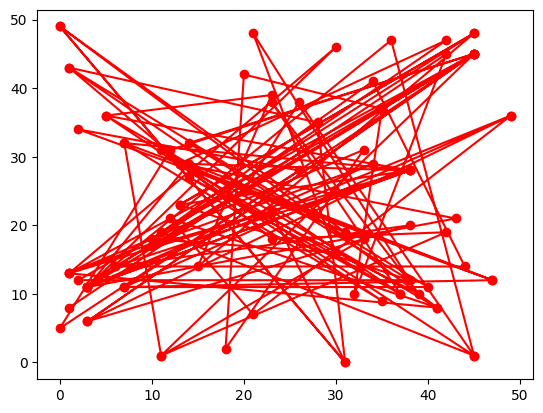

0.7807144606888387
第7个时刻, 有42165辆车


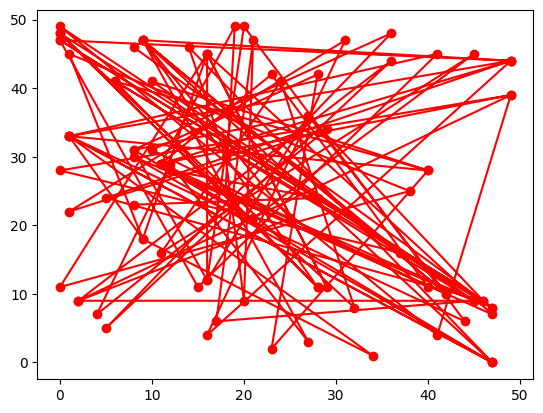

0.4401805528131842
第8个时刻, 有46066辆车


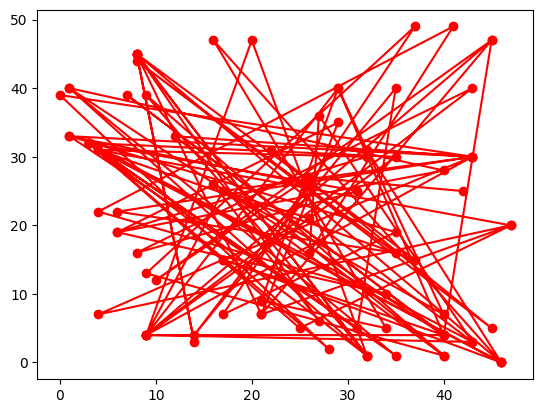

0.7456014696090177
第9个时刻, 有52270辆车


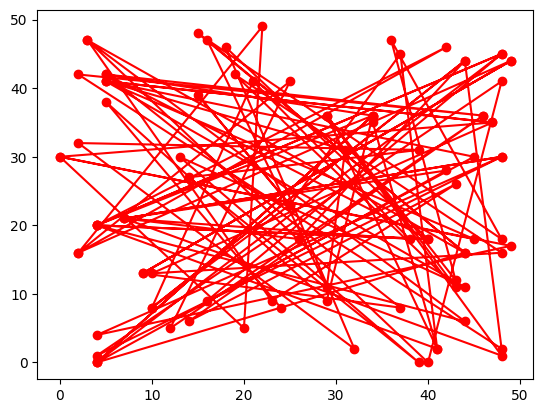

0.48105369288322053
第10个时刻, 有56598辆车


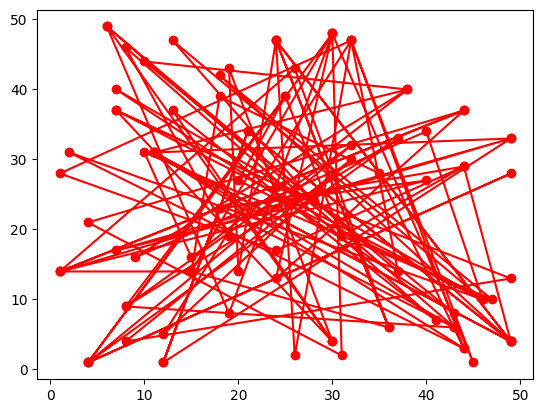

0.6779529694748129
第11个时刻, 有63707辆车


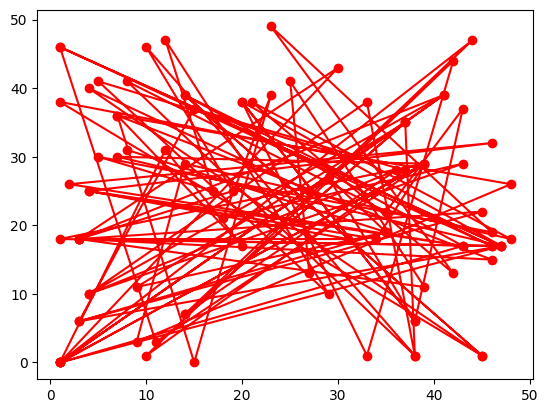

0.4439458970447482
第12个时刻, 有71140辆车


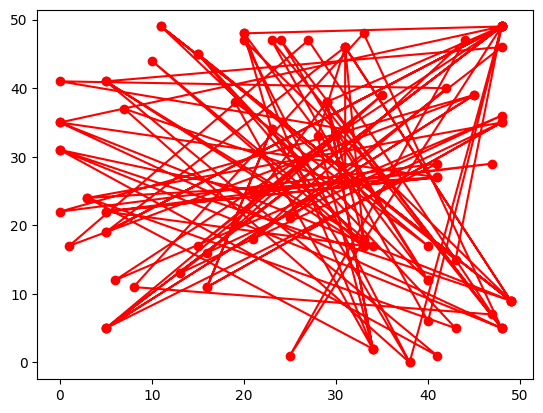

0.6198043333342533
第13个时刻, 有78705辆车


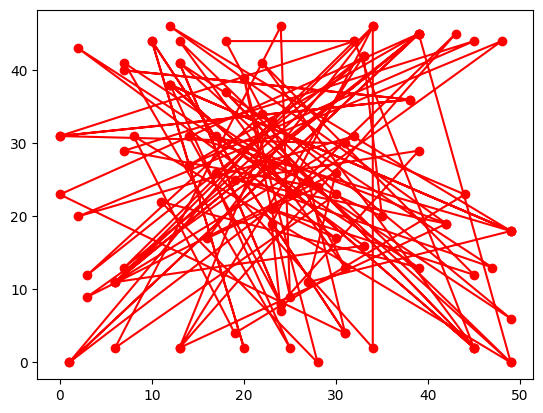

0.4406061928397789
第14个时刻, 有86092辆车


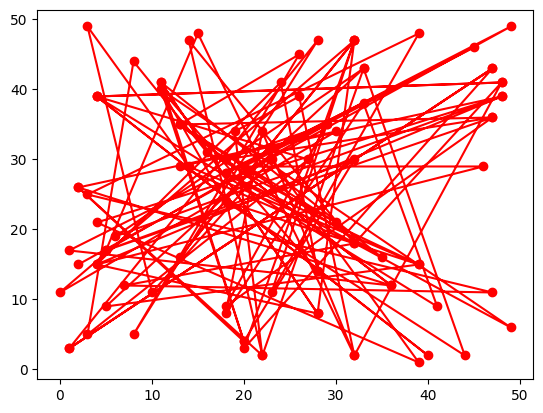

0.5917828016871649
第15个时刻, 有92843辆车


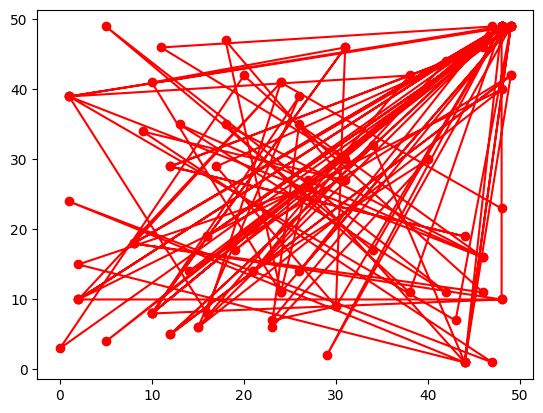

0.39479660337661077
第16个时刻, 有101376辆车


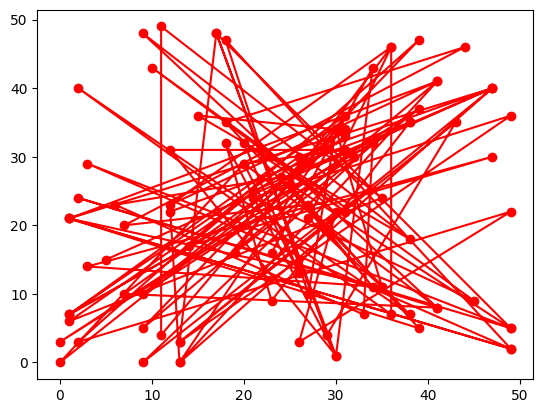

0.5199998344722989
第17个时刻, 有109372辆车


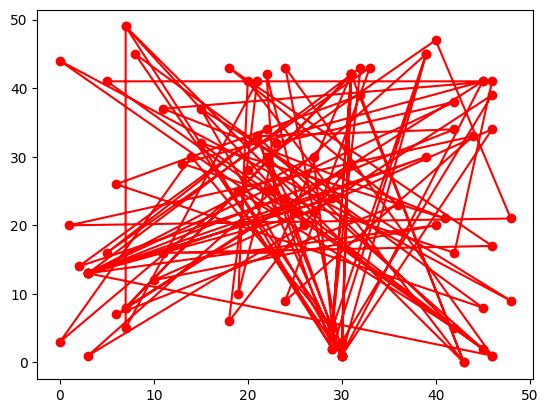

0.2591749631131414
第18个时刻, 有117493辆车


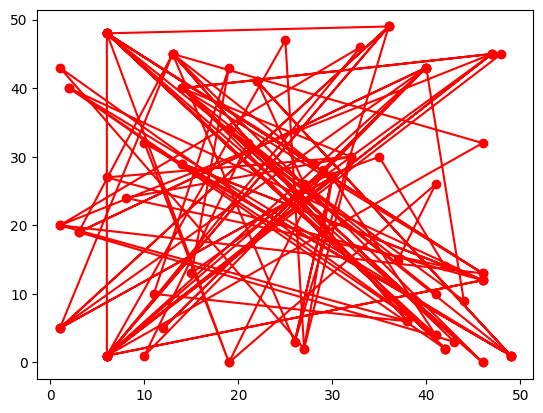

0.19538219432228784
第19个时刻, 有125016辆车


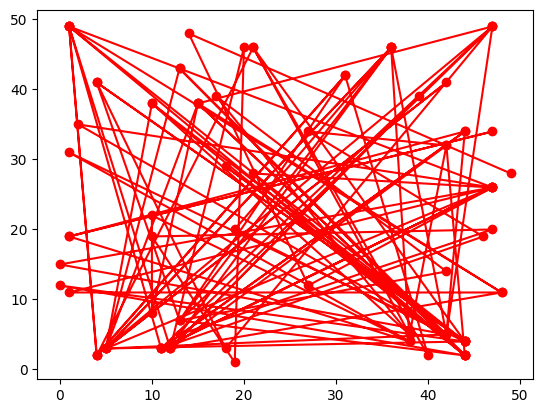

KeyboardInterrupt: 

In [214]:
# 方案二: 遗传算法
import numpy as np
import matplotlib.pyplot as plt
from sko.GA import GA_TSP
from scipy import spatial
from sko.GA import GeneticAlgorithmBase

def distance(x_1, y_1, x_2, y_2):
    return np.sqrt((x_1 - x_2) ** 2 + (y_1 - y_2) ** 2)

def encode_point(x, y):
    return y * 50 + x

def decode_point(point):
    return (point % 50, point // 50)

def cal_routine_distance(routine):
    num_points, = routine.shape
    x_points = [decode_point(i)[0] for i in routine]
    y_points = [decode_point(i)[1] for i in routine]
    sum_distance = 0
    for i, (x, y) in enumerate(zip(x_points, y_points)):
        if i == 0:
            continue
        x_s, y_s = x_points[i-1], y_points[i-1]
        sum_distance += distance(x_s, y_s, x, y)
    return sum_distance

def cal_bike_used_rate(routine):
    num_points, = routine.shape
    graph_temp = store_graph.copy()
    sum_bike_on_routine = 0
    x_points = [decode_point(i)[0] for i in routine]
    y_points = [decode_point(i)[1] for i in routine]
    for i, (x, y) in enumerate(zip(x_points, y_points)):
        if i == 0:
            continue
        x_s, y_s = x_points[i-1], y_points[i-1]
        sum_bike_on_routine += graph_temp[y_s, x_s]
        graph_temp[y_s, x_s] = 0
    for i, (x, y) in enumerate(zip(x_points, y_points)):
        if i == 0:
            continue
        graph_temp[y, x] = sum_bike_on_routine//num_points
    sum_bike_on_graph = np.sum(graph_temp > 0)
    used_bike_on_graph = np.minimum(graph_temp, need_graph)
    sum_import_bike = np.sum(-graph_temp[graph_temp < 0])
    graph_temp[graph_temp < 0] = 0
    return sum_import_bike - cal_routine_distance(routine)

def change_the_store(routine, store_graph, need_graph):
    num_points, = routine.shape
    sum_bike_on_graph = np.sum(store_graph)
    routine_bike_sum = 0
    for i in range(num_points):
        x, y = decode_point(routine[i])
        routine_bike_sum += store_graph[y, x]
        store_graph[y, x] = 0
    for i in range(num_points):
        x, y = decode_point(routine[i])
        store_graph[y, x] += routine_bike_sum/num_points
    
    import_bike = np.sum(-store_graph[store_graph < 0])
    
    
    used_bike_on_graph = np.sum(np.minimum(store_graph, need_graph))
    store_graph[store_graph < 0] = 0
    
    return store_graph, import_bike, used_bike_on_graph, sum_bike_on_graph

# 每个时刻的需求量
time_heatmap_start = np.loadtxt('time_heatmap_12.csv', delimiter=',').reshape((-1, 50, 50))
time_heatmap_end = np.loadtxt('time_heatmap_12_end.csv', delimiter=',').reshape((-1, 50, 50))

store_graph = np.zeros((50, 50))
used_rate_list = []
bike_amount = 0
for i,(need_graph, move_graph) in enumerate(zip(time_heatmap_start, time_heatmap_end)):
    ga_tsp = PathTSP(func=cal_bike_used_rate, n_dim=200, size_pop=100, max_iter=2000, prob_mut=1, rand_range=2500)
    if i == 0:
        continue
    best_points, best_bike_num = ga_tsp.run()
    store_graph, import_bike, used_bike_on_graph, sum_bike_on_graph = change_the_store(best_points, store_graph, need_graph)
    bike_amount += import_bike
    
    used_rate_list.append(used_bike_on_graph/(sum_bike_on_graph))
    print(used_bike_on_graph/sum_bike_on_graph)
    points_list = [decode_point(i) for i in best_points]
    #print(points_list)
    print('第{}个时刻, 有{}辆车'.format(i, (int)(sum_bike_on_graph)))
    store_graph = store_graph + move_graph - need_graph
    
    plt.plot([i[0] for i in points_list], [i[1] for i in points_list], 'o-r')
    plt.show()

plt.plot(used_rate_list[2:])
plt.show()

